In [39]:
import atd2022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_mod as util
import importlib
importlib.reload(util)

<module 'my_mod' from 'c:\\Users\\Work Space\\Desktop\\LISP-ATD-2022\\my_mod.py'>

In [4]:
print("12")

12


In [5]:
pd.options.display.max_columns = None

# 1-dim CNN experiment on 20-dim time series vector

# Data Import/Preprocessing

In [6]:
data = atd2022.io.read_csv()

In [7]:
test_region=data["AA"]

In [8]:
len(test_region)

215

In [9]:
test_region.tail(6)

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-01/2018-01-07,7,5,26,22,5,0,0,1,1,0,3,1,0,0,0,0,1,0,0,0
2018-01-08/2018-01-14,13,9,20,85,4,2,0,2,8,0,0,0,0,0,0,1,8,0,0,0
2018-01-15/2018-01-21,14,5,8,10,1,0,0,1,0,1,0,1,0,0,0,0,3,0,2,0
2018-01-22/2018-01-28,5,2,0,23,3,2,5,1,0,0,2,0,0,0,0,3,4,0,4,0
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [10]:
test=util.getMultiDXY(test_region, n_lags=2)

In [11]:
test

(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 2.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  3., ...,  0.,  1.,  0.]],
 
        [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]],
 
        ...,
 
        [[13.,  9., 20., ...,  0.,  0.,  0.],
         [14.,  5.,  8., ...,  0.,  2.,  0.]],
 
        [[14.,  5.,  8., ...,  0.,  2.,  0.],
         [ 5.,  2.,  0., ...,  0.,  4.,  0.]],
 
        [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
         [ 3.,  2.,  7., ...,  0.,  0.,  0.]]]),
 array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 6.,  1., 59., ...,  0.,  0.,  0.],
        ...,
        [ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.],
        [ 7.,  6.,  7., ...,  0.,  4.,  0.]]))

In [12]:
x,y = util.getMultiDXY(test_region, n_lags=2)

In [13]:
x

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  3., ...,  0.,  1.,  0.]],

       [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[13.,  9., 20., ...,  0.,  0.,  0.],
        [14.,  5.,  8., ...,  0.,  2.,  0.]],

       [[14.,  5.,  8., ...,  0.,  2.,  0.],
        [ 5.,  2.,  0., ...,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.]]])

In [14]:
y

array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 6.,  1., 59., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  2.,  0., ...,  0.,  4.,  0.],
       [ 3.,  2.,  7., ...,  0.,  0.,  0.],
       [ 7.,  6.,  7., ...,  0.,  4.,  0.]])

In [15]:
y.shape

(213, 20)

In [16]:
x.shape

(213, 2, 20)

In [17]:
# (#of samples, timesteps, #features(i.e. number of parallel time series))

In [18]:
n_features = 20
x_train=x.reshape((x.shape[0], x.shape[1], n_features))

In [19]:
x_train.shape

(213, 2, 20)

In [20]:
y_train=y

# CNN Model Building

In [21]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import gc
device=torch.device("cpu")

In [22]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(2,128,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1,128)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [23]:
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [24]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [25]:
train = myDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [26]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs=inputs.to(torch.float32)
        labels=labels.to(torch.float32)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad(set_to_none = True)
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')

def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [27]:
epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    #Valid()
    gc.collect()

epochs 1/20


c:\Users\Work Space\anaconda3\envs\atd2022\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 100.62415313720703
epochs 2/20
train_loss 99.11529541015625
epochs 3/20
train_loss 97.80622863769531
epochs 4/20
train_loss 96.71733856201172
epochs 5/20
train_loss 95.82682037353516
epochs 6/20
train_loss 95.11397552490234
epochs 7/20
train_loss 94.54776763916016
epochs 8/20
train_loss 94.10066986083984
epochs 9/20
train_loss 93.74574279785156
epochs 10/20
train_loss 93.46341705322266
epochs 11/20
train_loss 93.2368392944336
epochs 12/20
train_loss 93.05132293701172
epochs 13/20
train_loss 92.89656066894531
epochs 14/20
train_loss 92.76448822021484
epochs 15/20
train_loss 92.65128326416016
epochs 16/20
train_loss 92.55224609375
epochs 17/20
train_loss 92.46381378173828
epochs 18/20
train_loss 92.38394165039062
epochs 19/20
train_loss 92.31094360351562
epochs 20/20
train_loss 92.24317169189453


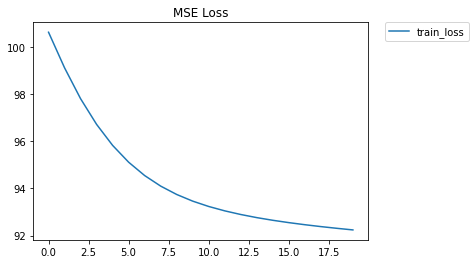

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
#plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Testing Set Preparation/Model testing

In [29]:
x_test, y_test=util.get_testXY(test_region, 4, 2)

In [30]:
x_test.shape

(4, 2, 20)

In [31]:
x_test

array([[[ 7.,  5., 26., 22.,  5.,  0.,  0.,  1.,  1.,  0.,  3.,  1.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.]],

       [[13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.],
        [14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.]],

       [[14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.],
        [ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.],
        [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [32]:
predictions = util.pred_next_n(x_test, model, 4)

In [33]:
predictions

[array([[2.6893497 , 5.842237  , 6.0904255 , 3.994162  , 5.601624  ,
         3.4844189 , 2.6982784 , 4.4729624 , 3.5942168 , 2.8001113 ,
         5.8086157 , 3.0380774 , 5.5160503 , 4.8629436 , 2.837581  ,
         0.64925253, 3.0555944 , 4.4847355 , 3.7781866 , 7.1430883 ]],
       dtype=float32),
 array([[6.4473343, 5.879306 , 5.514781 , 3.8106718, 6.3918004, 6.4715643,
         2.496686 , 4.83812  , 5.752984 , 2.4935865, 4.55507  , 3.7489078,
         5.793228 , 5.2333555, 3.6266108, 1.7472315, 5.505238 , 4.6660595,
         3.6633053, 5.9692354]], dtype=float32),
 array([[2.8562186 , 3.5090914 , 3.1644928 , 3.149423  , 4.2073627 ,
         2.7444181 , 2.2877061 , 3.4513683 , 3.3884735 , 2.4354503 ,
         3.0683086 , 2.592679  , 3.8825872 , 3.167643  , 2.0707748 ,
         0.25867742, 2.5498579 , 2.8561645 , 3.055162  , 5.0652285 ]],
       dtype=float32),
 array([[2.4405036 , 2.5350575 , 2.3985898 , 1.7521927 , 3.7035205 ,
         2.3236356 , 1.824832  , 1.9990069 , 2.8166945 

In [34]:
util.metrics_mse(predictions, y_test)

20.59588149371134
33.181778775756456
66.68613698360815
118.4113351004255


In [35]:
test=test_region.tail(2)

In [36]:
test

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [37]:
pred = util.prod_pred_next_n(test, model)

1
2
3
4
(2, 20)
[2.4772427 4.50922   3.6403193 3.4262872 3.6347022 2.958684  1.9138889
 2.8812206 3.1682062 1.8425845 3.2915425 1.9871057 3.8958838 4.1793947
 2.1591518 0.5805316 1.9707905 3.144789  3.1595054 5.1526394]
[3.8355355 3.8657155 3.4330502 2.4134107 3.9334013 3.949173  1.7990553
 3.0415277 3.6036968 1.6558921 2.477667  2.1989465 3.6550956 3.378253
 2.446856  0.9189644 3.0924268 2.986939  2.4984431 4.0910063]
[1.5759301  2.006458   2.305821   1.2353344  2.7527623  1.6332228
 1.4621236  1.2738433  2.0397015  1.7893977  1.2526515  0.87015903
 2.7889538  1.625197   1.9450643  0.13637395 0.9379002  1.9117401
 1.8145769  3.866825  ]
[1.7494783  1.5951643  1.689508   1.270766   2.206392   1.5803983
 1.2717195  1.2459772  1.9531125  1.5000993  1.0677478  0.8193854
 2.1923518  1.2984941  1.6529312  0.18337733 1.0509126  1.6258028
 1.4141316  3.0460086 ]
